# CA684 Machine Learning Assignment Spring 2024

DCU has teamed up with **Etsy** to create the 2024 CA684 Machine Learning assignment.

## Challenge

Etsy has nearly 100 Million active listings on the etsy.com marketplace for sale from more than 5 million active sellers. You are provided a subset of those products as the training data.

The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

- top category id
- bottom category id
- primary color id
- secondary color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category, primary color and secondary color). Your approaches and models will be benchmarked against a hidden test dataset.


In [2]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

In [3]:
# set random seed
np.random.seed(seed=42)

In [4]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LOAD DATASET**

In [5]:
# Define the path to your datasets
PATH = '/content/drive/MyDrive'

In [6]:
import pandas as pd
# Load train dataset
train_df = pd.read_parquet('/content/drive/MyDrive/train')

In [7]:
# Load test dataset
test_df = pd.read_parquet('/content/drive/MyDrive/test')

# Check the first few rows of the train dataset
print(train_df.head())

# Check the first few rows of the test dataset
print(test_df.head())


   product_id                                              title  \
0   957886356  Silver Halo Crown, Halo Crown Headpiece, Boho ...   
1  1648590088                              Pretty Pink Rose Halo   
2  1650063588  Stefana Wedding ,Crowns,Greek Orthodox Ceremon...   
3   634349358  Silver Flapper Headband Great Gatsby Headband ...   
4  1287035807  Trendy clear Tiara, Crystal Wedding Crown Prin...   

                                         description  \
0  Hello, I would like to introduce you our new b...   
1  Feminine, Romantic and Classic!!!\nTwin Rose H...   
2  Handemade Boho stefana for a special wedding w...   
3  Silver Flapper Headband Great Gatsby Headband ...   
4  💕Elegant and sparkling✨️, this tiara features ...   

                                                tags      type room  \
0  halo crown,halo crown headpiece,met gala crown...  physical        
1                                Pink Rose Headpiece  physical        
2  Wedding,bridal crowns,greek tiaras,gre

# **DATA PREPROCESSING**

In [8]:
import pandas as pd

# Load or create your df_train and df_test DataFrames here
# For example:
train_df = pd.read_parquet('/content/drive/MyDrive/train')
test_df = pd.read_parquet('/content/drive/MyDrive/test')


# Preprocessing and cleaning
# Assuming you want to drop missing values and remove any duplicate rows
df_train_cleaned = train_df.dropna().drop_duplicates()
df_test_cleaned = test_df.dropna().drop_duplicates()

# Print the first few rows of the cleaned datasets
print("First few rows of cleaned training dataset:")
print(df_train_cleaned.head())

print("\nFirst few rows of cleaned test dataset:")
print(df_test_cleaned.head())


First few rows of cleaned training dataset:
   product_id                                              title  \
0   957886356  Silver Halo Crown, Halo Crown Headpiece, Boho ...   
1  1648590088                              Pretty Pink Rose Halo   
2  1650063588  Stefana Wedding ,Crowns,Greek Orthodox Ceremon...   
3   634349358  Silver Flapper Headband Great Gatsby Headband ...   
4  1287035807  Trendy clear Tiara, Crystal Wedding Crown Prin...   

                                         description  \
0  Hello, I would like to introduce you our new b...   
1  Feminine, Romantic and Classic!!!\nTwin Rose H...   
2  Handemade Boho stefana for a special wedding w...   
3  Silver Flapper Headband Great Gatsby Headband ...   
4  💕Elegant and sparkling✨️, this tiara features ...   

                                                tags      type room  \
0  halo crown,halo crown headpiece,met gala crown...  physical        
1                                Pink Rose Headpiece  physical      

# **EXPLORATORY DATA ANALYSIS**

       top_category_id  bottom_category_id  primary_color_id  \
count     37840.000000        37840.000000      37840.000000   
mean          6.935042         3497.931131          8.603409   
std           3.678195         3790.211330          6.377306   
min           0.000000           13.000000          0.000000   
25%           5.000000         1001.000000          2.000000   
50%           8.000000         1871.000000          9.000000   
75%           9.000000         6290.000000         14.000000   
max          14.000000        12493.000000         19.000000   

       secondary_color_id  
count        37840.000000  
mean             9.479123  
std              6.431204  
min              0.000000  
25%              2.000000  
50%             10.000000  
75%             16.000000  
max             19.000000  


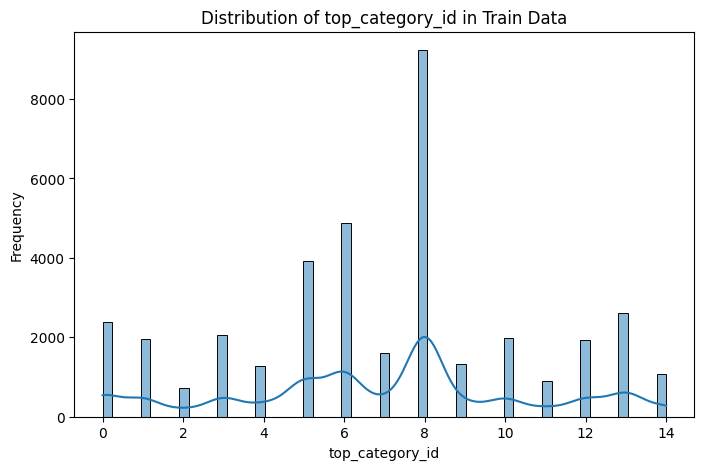

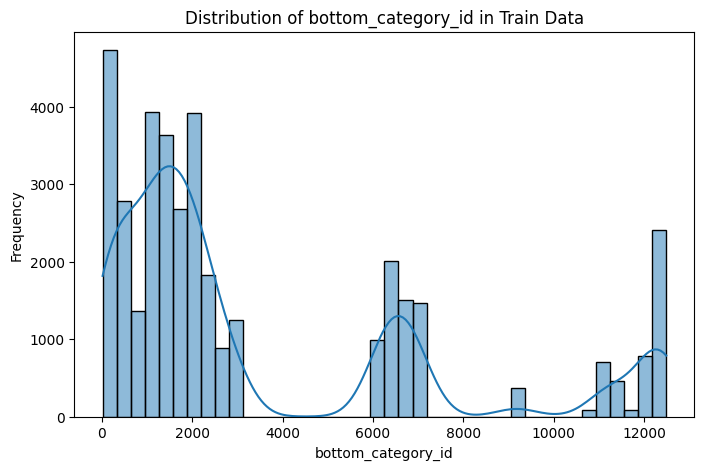

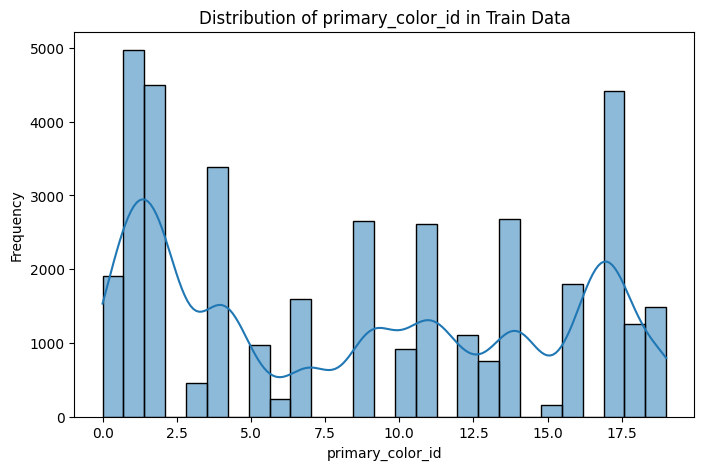

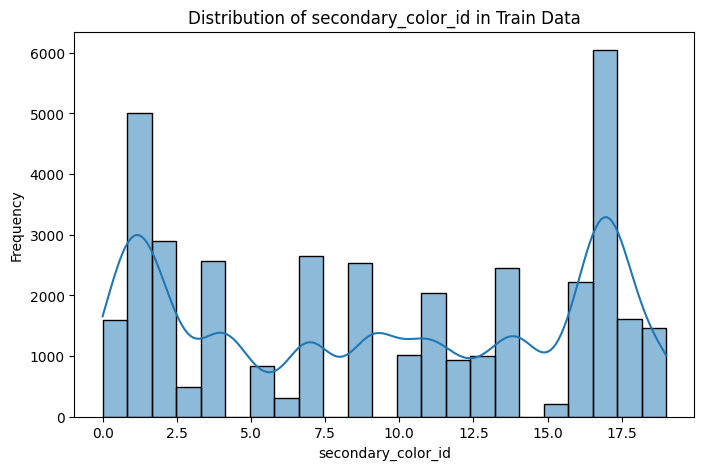

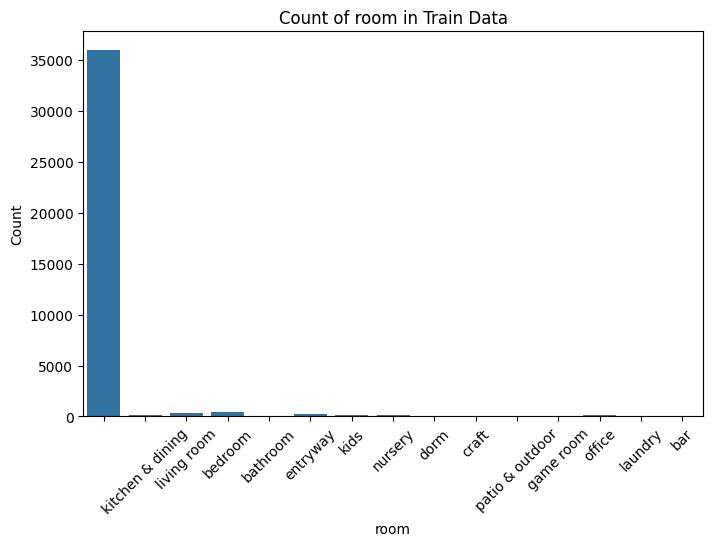

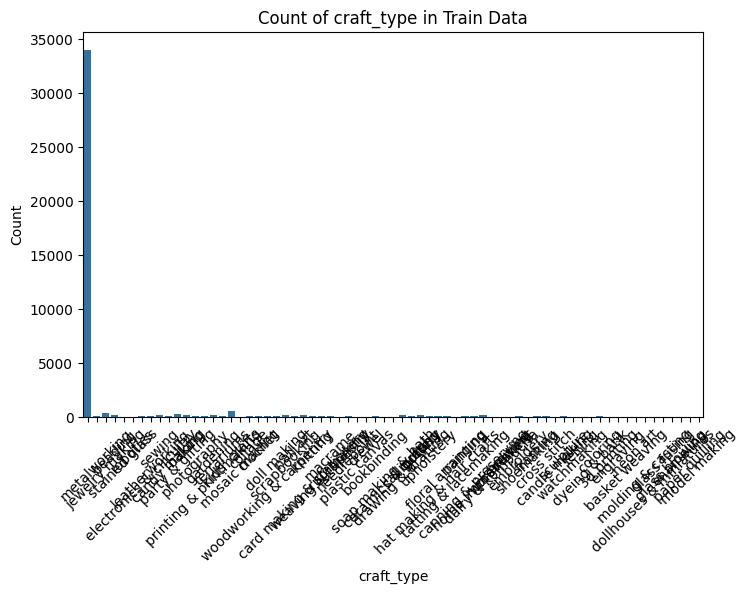

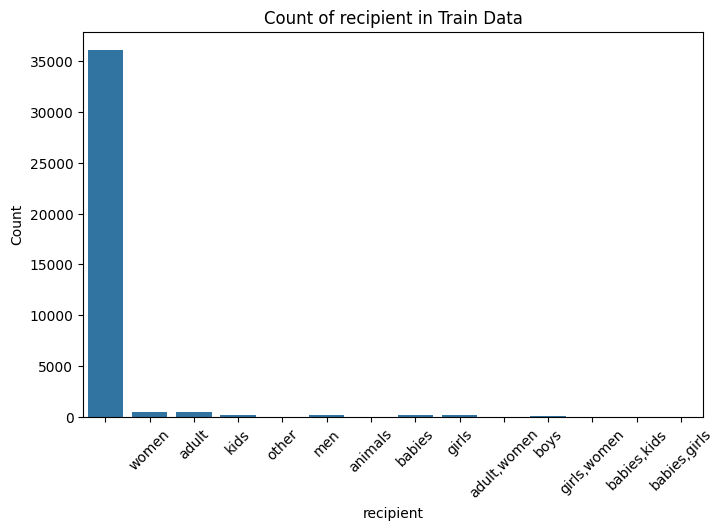

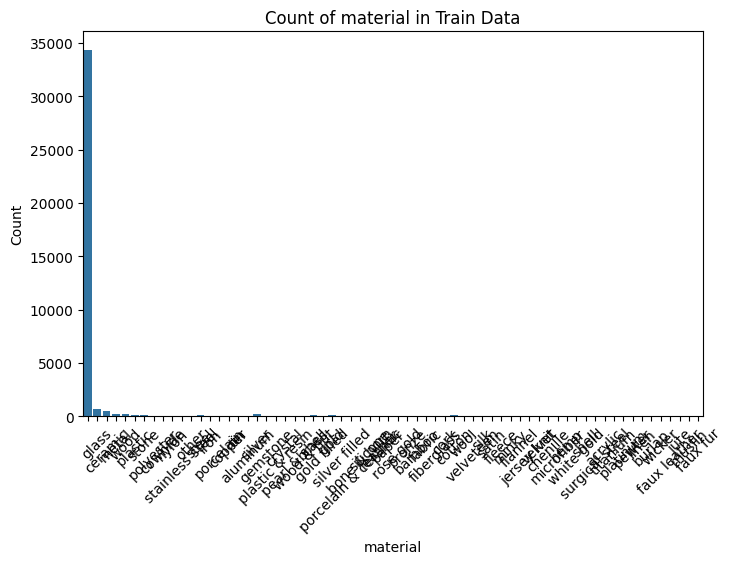

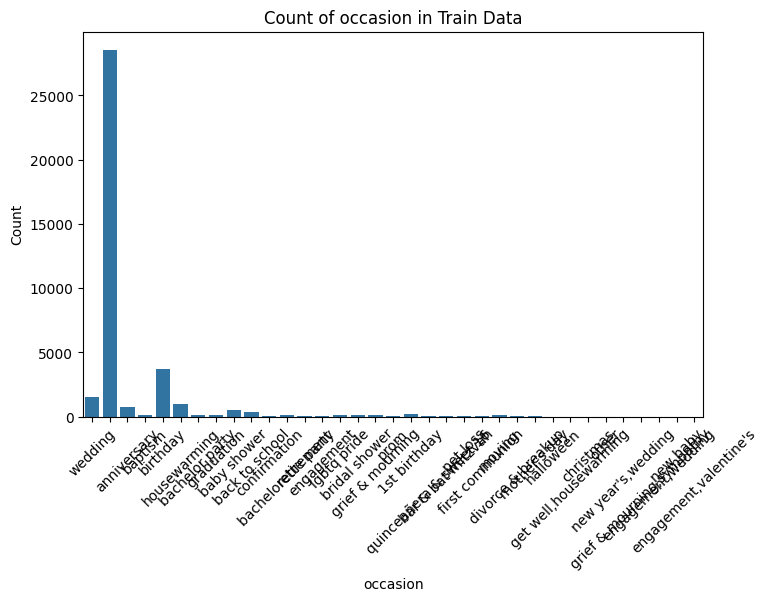

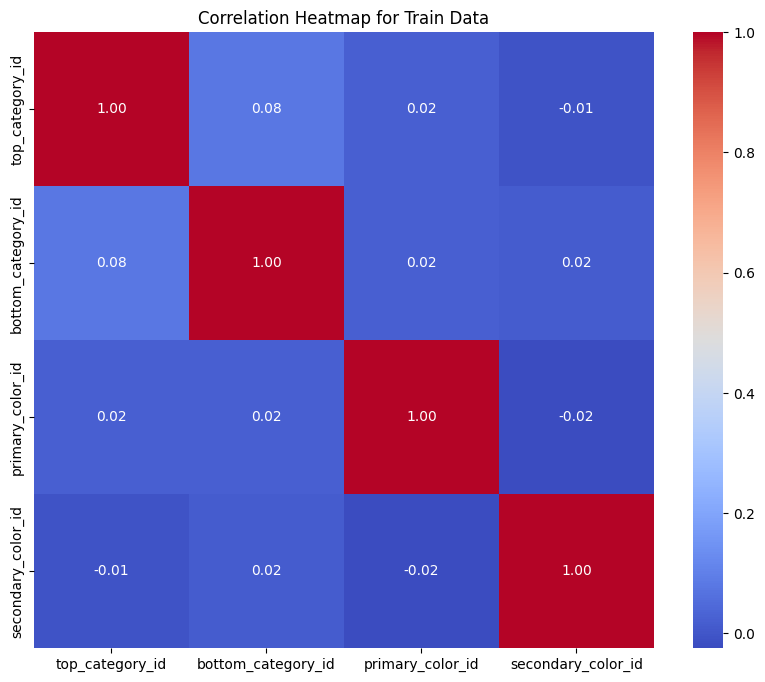

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load train dataset
train_df = pd.read_parquet('/content/drive/MyDrive/train')

# Load test dataset
test_df = pd.read_parquet('/content/drive/MyDrive/test')

# Summary statistics for numerical columns
numerical_cols = ['top_category_id', 'bottom_category_id', 'primary_color_id', 'secondary_color_id']
summary_stats = train_df[numerical_cols].describe()
print(summary_stats)

# Data Visualization

# Histograms for numerical variables
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=train_df, x=col, kde=True)
    plt.title(f'Distribution of {col} in Train Data')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Count plots for categorical variables
categorical_cols = ['room', 'craft_type', 'recipient', 'material', 'occasion']
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_df, x=col)
    plt.title(f'Count of {col} in Train Data')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap for numerical variables in train data
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Train Data')
plt.show()


# **CLASSIFICATION USING ML**

Accuracy: 0.8888742071881607
Confusion Matrix:
[[ 373    1    6   15    0    4    0    2   20    3    3    2    2   11
     8]
 [   5  325    0    3    0   10    0    0   20    0    2    0    0   29
     7]
 [   2    0  145    3    1    2    0    0    0    1    0    0    0    2
     0]
 [  12    0    6  362    3    9    0    0   19    1    2    0    0    7
     0]
 [   1    0    2   10  200    1    0    1   20    0    1    0    0    1
     0]
 [   7   12    4    2    1  700    0    1   11    0    3    0    0    2
     9]
 [   0    0    0    0    0    0  965    0    9    0    2    0    0    0
     0]
 [   7    0    0    0    0    3    0  282   24    0    6    0    0    0
     0]
 [  32   12    1   18   10   17   30   13 1670    7   23    1    3   23
     6]
 [   3    0    2    2    0    4    0    0    6  255    3    1    0    6
     4]
 [   0    2    2    2    2    5    6    5   26    7  329    4    0    5
     7]
 [   0    1    0    0    0    0    0    0    4    1    5  185    4    0
 

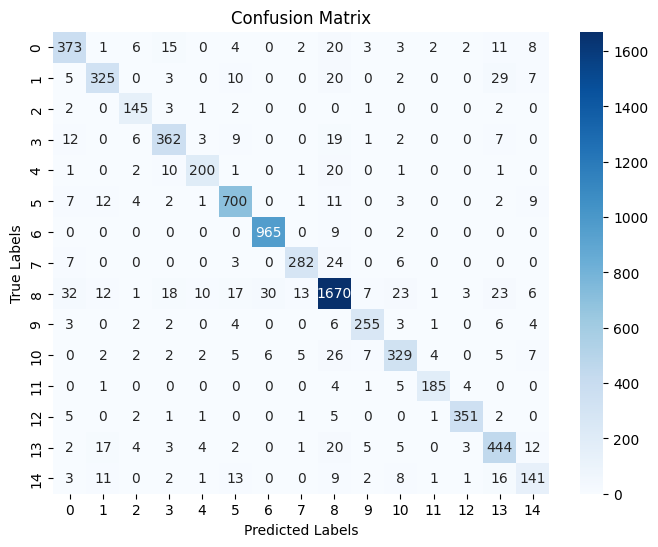

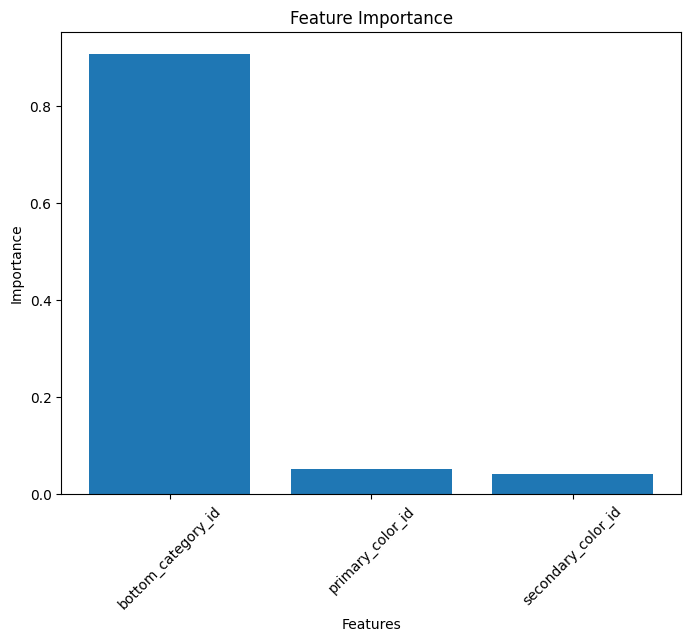

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Load the dataset
df = pd.read_parquet('/content/drive/MyDrive/train')

# Define features and target variable
X = df[[ 'bottom_category_id', 'primary_color_id', 'secondary_color_id']]
y = df['top_category_id']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

# Visualization - Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Visualization - Feature Importance
feature_importance = clf.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(X.columns, feature_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()